# Default Estimator and Weight of Evidence (WoE) Binning

### RFMS Model:

The RFM model is a widely used customer segmentation method that categorizes customers based on three critical transactional dimensions: Recency, Frequency, and Monetary Value.

### Implementation Steps:

1. **Data Preparation:**

- Ensure the transaction dataset contains necessary columns such as TransactionId, CustomerId, TransactionStartTime, and Amount.

2. **Calculate Last Access Date:**

- Identify the most recent transaction date for each customer to measure recency.

3. **Calculate RFM Scores:**

- Compute metrics for Recency, Frequency, and Monetary value for each customer using predefined formulas.

These steps provide insights into customer behavior, allowing businesses to group customers effectively based on their transactional habits.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os
import sys
from importlib import reload

sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

In [2]:
df= pd.read_csv('../data/normalized_data.csv')

In [3]:
from modeling import RFMAnalysis

# Initialize RFMS object
rfm = RFMAnalysis(df.reset_index())

In [4]:
rfm

In [5]:
# Instantiate the RFMAnalysis class
rfm = RFMAnalysis(df)

### **Step 1:** Calculate Recency, Frequency, and Monetary

In [48]:
import pandas as pd
from datetime import datetime
import pytz

class RFMAnalysis:
    """
    A utility class for calculating Recency, Frequency, and Monetary (RFM) metrics for customer transaction data.
    """

    def __init__(self, transaction_data):
        """
        Initialize the RFMAnalysis class with the provided transaction data.

        Parameters:
        -----------
        transaction_data : pd.DataFrame
            The dataset containing customer transactions.
        """
        self.data = transaction_data

    def compute_rfm_metrics(self):
        """
        Compute Recency, Frequency, and Monetary metrics for each customer.

        Returns:
            pd.DataFrame: A DataFrame with calculated RFM metrics.
        """
        # Ensure transaction timestamps are in datetime format
        self.data['TransactionStartTime'] = pd.to_datetime(self.data['TransactionStartTime'])

        # Define the current date for recency calculation (use UTC for consistency)
        current_date = pd.Timestamp.now(tz=pytz.UTC)

        # Calculate Recency: Days since the customer's last transaction
        self.data['LastTransaction'] = self.data.groupby('CustomerId')['TransactionStartTime'].transform('max')
        self.data['Recency'] = (current_date - self.data['LastTransaction']).dt.days

        # Calculate Frequency: Total number of transactions per customer
        self.data['Frequency'] = self.data.groupby('CustomerId')['TransactionId'].transform('count')

        # Calculate Monetary: Total transaction amount per customer
        self.data['Monetary'] = self.data.groupby('CustomerId')['Amount'].transform('sum')

        # Create a summary DataFrame with unique Customer IDs
        rfm_summary = self.data[['CustomerId', 'Recency', 'Frequency', 'Monetary']].drop_duplicates()
        return rfm_summary
    
    def plot_pairplot(self):
        """
        Create a pairplot to visualize relationships between Recency, Frequency, and Monetary.
        """
        sns.pairplot(self.data[['Recency', 'Frequency', 'Monetary']])
        plt.suptitle('Pair Plot of RFM Variables', y=1.02)
        plt.show()

    def plot_heatmap(self):
        """
        Create a heatmap to visualize correlations between RFM variables.
        """
        corr = self.data[['Recency', 'Frequency', 'Monetary']].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of RFM Variables')
        plt.show()

    def plot_histograms(self):
        """
        Plot histograms for Recency, Frequency, and Monetary.
        """
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        self.data['Recency'].hist(bins=20, ax=axes[0])
        axes[0].set_title('Recency Distribution')
        self.data['Frequency'].hist(bins=20, ax=axes[1])
        axes[1].set_title('Frequency Distribution')
        self.data['Monetary'].hist(bins=20, ax=axes[2])
        axes[2].set_title('Monetary Distribution')
        plt.tight_layout()
        plt.show()

    def calculate_rfm_scores(self, rfm_data):
        """
        Calculates RFM scores based on the Recency, Frequency, and Monetary values.

        Args:
            rfm_data (pandas.DataFrame): A DataFrame containing Recency, Frequency, and Monetary values.

        Returns:
            pandas.DataFrame: A DataFrame with additional columns for RFM scores.
        """
        
        # Quantile-based scoring
        rfm_data['r_quartile'] = pd.qcut(rfm_data['Recency'], 4, labels=['4', '3', '2', '1'])  # Lower recency is better
        rfm_data['f_quartile'] = pd.qcut(rfm_data['Frequency'], 4, labels=['1', '2', '3', '4'])  # Higher frequency is better
        rfm_data['m_quartile'] = pd.qcut(rfm_data['Monetary'], 4, labels=['1', '2', '3', '4'])  # Higher monetary is better

        # Calculate overall RFM Score
        rfm_data['RFM_Score'] = (rfm_data['r_quartile'].astype(int) * 0.1 +
                                  rfm_data['f_quartile'].astype(int) * 0.45 +
                                  rfm_data['m_quartile'].astype(int) * 0.45)

        return rfm_data
    
    
    def assign_label(self, rfm_data):
        """ 
        Assign 'Good' or 'Bad' based on the RFM Score threshold (e.g., median).
        
        Args:
            rfm_data (pandas.DataFrame): A DataFrame with RFM scores.
        
        Returns:
            pandas.DataFrame: Updated DataFrame with Risk_Label column.
        """
        high_threshold = rfm_data['RFM_Score'].quantile(0.75)  # Change to .75 to include moderate users
        low_threshold = rfm_data['RFM_Score'].quantile(0.5)  # Change to .25 to include moderate users
        rfm_data['Risk_Label'] = rfm_data['RFM_Score'].apply(lambda x: 'Good' if x >= low_threshold else 'Bad')
        return rfm_data

In [7]:
# Example usage
if __name__ == '__main__':
    # Instantiate the RFMAnalysis class
    rfm = RFMAnalysis(df)

    # Step 1: Calculate Recency, Frequency, and Monetary
    rfm_df = rfm.compute_rfm_metrics()

    # Display the first five rows
    print(rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary']].head())

        CustomerId  Recency  Frequency   Monetary
0  CustomerId_4406     2104        119  109921.75
2  CustomerId_4683     2184          2    1000.00
3   CustomerId_988     2108         38  228727.20
5  CustomerId_1432     2194          1    2000.00
6  CustomerId_2858     2108         29   93400.00


### Visualize the values

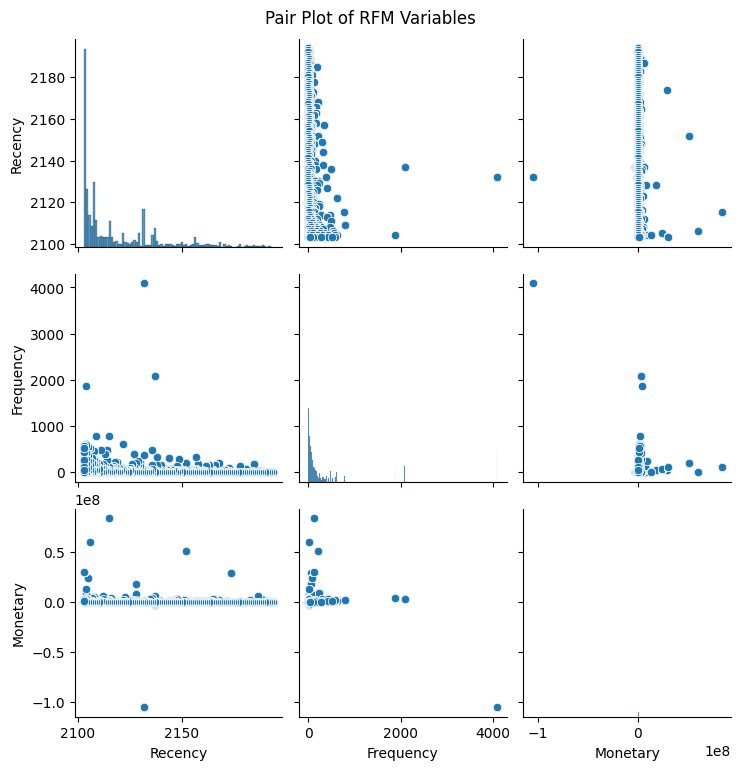

In [8]:
rfm = RFMAnalysis(df)
rfm.plot_pairplot()

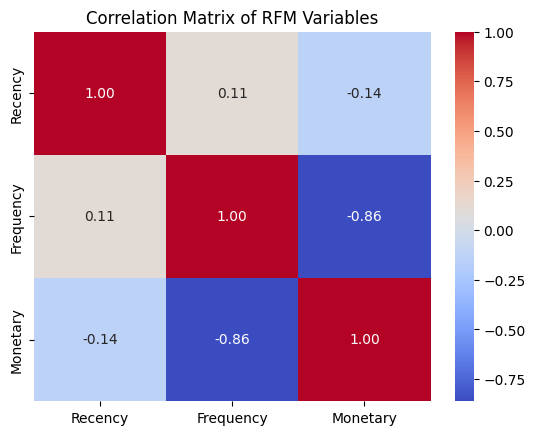

In [9]:
rfm.plot_heatmap()

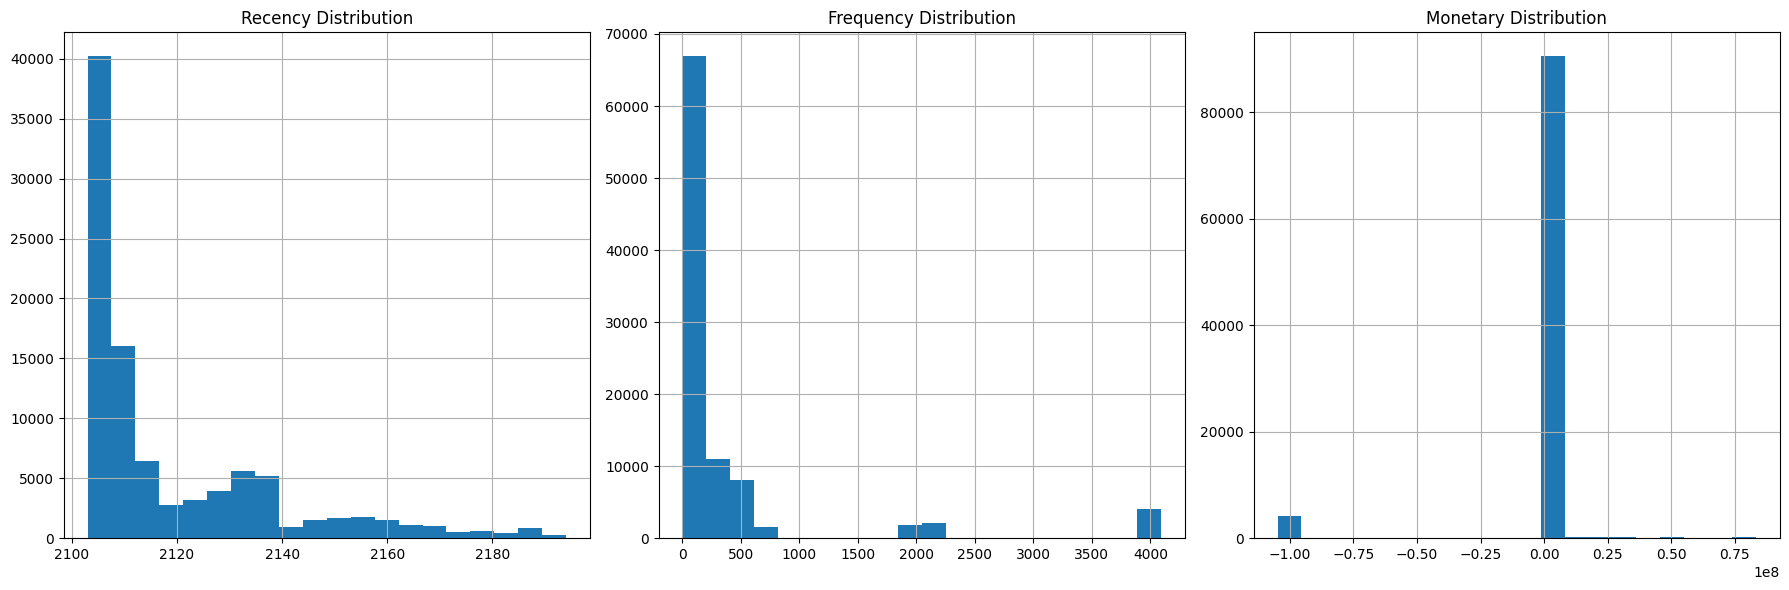

In [10]:
rfm. plot_histograms()

In [11]:
# Call the calculate_rfm_scores method to compute the overall RFM score

# Calculate RFM scores
rfm_df_scores = rfm.compute_rfm_metrics()

In [12]:
rfm = RFMAnalysis(df)

rfm_df_scores = rfm.calculate_rfm_scores(df)
rfm_df_scores = rfm.assign_label(df)

In [13]:
# Display the updated rfms_data DataFrame
rfm_df_scores[['CustomerId',	'Recency',	'Frequency',	'Monetary', 'RFM_Score', 'Risk_Label']].head(10)

,CustomerId,Recency,Frequency,Monetary,RFM_Score,Risk_Label
0,CustomerId_4406,2104,119,109921.75,2.65,Good
1,CustomerId_4406,2104,119,109921.75,2.65,Good
2,CustomerId_4683,2184,2,1000.00,1.00,Bad
3,CustomerId_988,2108,38,228727.20,2.55,Good
4,CustomerId_988,2108,38,228727.20,2.55,Good
5,CustomerId_1432,2194,1,2000.00,1.00,Bad
6,CustomerId_2858,2108,29,93400.00,1.65,Bad
7,CustomerId_2858,2108,29,93400.00,1.65,Bad
8,CustomerId_598,2192,4,8060.00,1.00,Bad
9,CustomerId_1053,2192,7,13788.00,1.00,Bad


In [14]:
risk_counts = rfm_df_scores['Risk_Label'].value_counts()

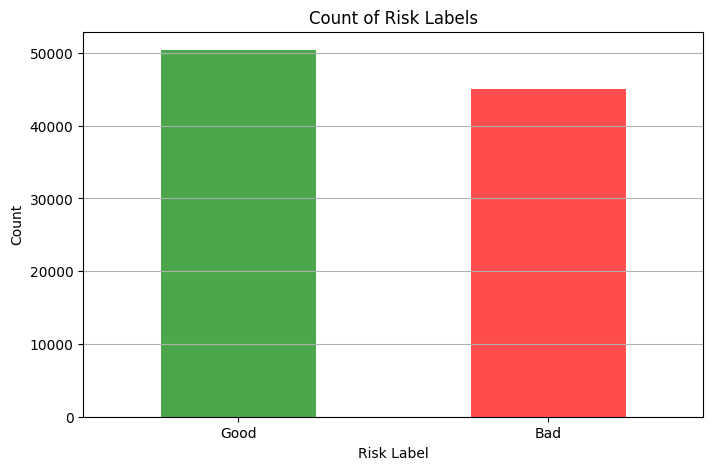

In [15]:
# Create the bar chart
plt.figure(figsize=(8, 5))
risk_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Count of Risk Labels')
plt.xlabel('Risk Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y')

# Show the plot
plt.show()

### **Perform Weight of Evidence (WoE) binning**

In [49]:
import numpy as np
class RFMAnalysiswoe:
    # Existing methods are omitted for brevity...
    
    def create_rfm_bins(self, rfm_df_scores, n_bins=5):
        """
        Create bins for RFM scores using quantiles.

        Parameters:
        -----------
        rfm_data : pd.DataFrame
            DataFrame containing the RFM scores.
        n_bins : int
            Number of bins to divide RFM scores into.

        Returns:
        --------
        pd.Series: Binned RFM scores.
        """
        return pd.qcut(rfm_df_scores['RFM_Score'], n_bins, labels=False, duplicates='drop')

    def calculate_counts(self, rfm_df_scores):
        """
        Calculate counts of high-value (good) and low-value (bad) customers in each bin.

        Parameters:
        -----------
        rfm_data : pd.DataFrame
            DataFrame with binned RFM scores and customer categories.

        Returns:
        --------
        tuple: Two Series containing counts of good and bad customers for each bin.
        """
        good_count = rfm_df_scores.groupby('RFM_bin')['CustomerCategory'].apply(lambda x: (x == 'High Value').sum())
        bad_count = rfm_df_scores.groupby('RFM_bin')['CustomerCategory'].apply(lambda x: (x == 'Low Value').sum())
        return good_count, bad_count

    def calculate_woe(self, good_count, bad_count):
        """
        Calculate Weight of Evidence (WoE) values for each bin.

        Parameters:
        -----------
        good_count : pd.Series
            Counts of good customers per bin.
        bad_count : pd.Series
            Counts of bad customers per bin.

        Returns:
        --------
        pd.Series: WoE values for each bin.
        """
        total_good = good_count.sum()
        total_bad = bad_count.sum()

        epsilon = 1e-10  # To avoid division by zero
        good_dist = good_count / (total_good + epsilon)
        bad_dist = bad_count / (total_bad + epsilon)

        woe = np.log((good_dist + epsilon) / (bad_dist + epsilon))
        return woe
    
    def label_customers(self, rfm_df_scores):
        """
    Classify customers into categories based on their RFM score.

    Parameters:
    -----------
    rfm_data : pd.DataFrame
        DataFrame with RFM scores.

    Returns:
    --------
    pd.DataFrame: Updated DataFrame with a category label for each customer.
        """
        threshold = rfm_df_scores['RFM_Score'].median()  # Use median as a threshold for categorization
        rfm_df_scores['CustomerCategory'] = rfm_df_scores['RFM_Score'].apply(
            lambda score: 'High Value' if score >= threshold else 'Low Value'
        )
    
        return rfm_df_scores
    

    def plot_rfm_bin_analysis(self, rfm_summary, good_count, bad_count):
        """
    Visualize the distribution of Good and Bad counts by RFM bins, 
    along with WoE and Bad Probability.

    Parameters:
    -----------
    rfm_df : pd.DataFrame
        The DataFrame containing RFM metrics and bins.
    good_count : pd.Series
        Series containing the counts of good (high-value) customers for each bin.
    bad_count : pd.Series
        Series containing the counts of bad (low-value) customers for each bin.
        """
    # Calculate Bad Probability
        bad_probability = bad_count / (good_count + bad_count)

    # Prepare the DataFrame for plotting
        plot_data = pd.DataFrame({
        'RFM_bin': good_count.index,
        'Good_Count': good_count.values,
        'Bad_Count': bad_count.values,
        'Bad_Probability': bad_probability.values,
        'RFM_woe': rfm_summary.groupby('RFM_bin')['RFM_woe'].first().values
        })

    # Plotting
        fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for Good and Bad Counts
        bar_width = 0.4
        index = plot_data['RFM_bin']

        bar1 = ax1.bar(index - bar_width / 2, plot_data['Good_Count'], width=bar_width, label='Good', color='lightgreen')
        bar2 = ax1.bar(index + bar_width / 2, plot_data['Bad_Count'], width=bar_width, label='Bad', color='lightcoral')

        ax1.set_xlabel('RFM Bins')
        ax1.set_ylabel('Count Distribution')
        ax1.set_title('Distribution of Good and Bad Customers by RFM Bins')
        ax1.legend(loc='upper left')

    # Adding WoE line
        ax2 = ax1.twinx()
        ax2.plot(index, plot_data['RFM_woe'], color='blue', marker='o', label='WoE', linewidth=2)
        ax2.set_ylabel('WoE', color='blue')

    # Annotate WoE values on the line
        for i, woe in enumerate(plot_data['RFM_woe']):
            ax2.text(index[i], woe, f'{woe:.2f}', color='blue', ha='center', fontsize=10)

    # Adding Bad Probability line
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))  # Move the third y-axis outward
        ax3.plot(index, plot_data['Bad_Probability'], color='orange', marker='s', label='Bad Probability', linewidth=2)
        ax3.set_ylabel('Bad Probability', color='orange')

    # Annotate Bad Probability values on the line
        for i, prob in enumerate(plot_data['Bad_Probability']):
            ax3.text(index[i], prob, f'{prob:.2f}', color='orange', ha='center', fontsize=10)

    # Show grid and adjust layout
        ax1.grid(True)
        ax1.set_xticks(index)
        ax1.set_xticklabels(plot_data['RFM_bin'])
        plt.tight_layout()
        plt.show()


In [52]:
rfm = RFMAnalysis(df)
# Step 1: Compute RFM metrics
rfm_summary = rfm.compute_rfm_metrics()

In [53]:
# Step 2: Assign RFM scores
rfm_summary = rfm.calculate_rfm_scores(rfm_summary)

In [54]:
rfm = RFMAnalysiswoe()
# Step 3: Categorize customers (High Value or Low Value)
rfm_summary = rfm.label_customers(rfm_summary)

# Step 4: Create RFM bins
rfm_summary['RFM_bin'] = rfm.create_rfm_bins(rfm_summary)

# Step 5: Calculate good and bad counts for each bin
good_count, bad_count = rfm.calculate_counts(rfm_summary)

# Step 6: Calculate WoE values
woe_values = rfm.calculate_woe(good_count, bad_count)

In [55]:
# Step 7: Map WoE values to the original DataFrame
woe_mapping = pd.Series(woe_values, index=good_count.index)
rfm_summary['RFM_woe'] = rfm_summary['RFM_bin'].map(woe_mapping)


In [56]:
rfm_df_scores

,Unnamed: 0.1,index,Unnamed: 0,TransactionId,CustomerId,Amount,TransactionStartTime,PricingStrategy,FraudResult,Total_Transactions,...,ChannelId_ChannelId_5,LastTransaction,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,Risk_Label
0,0,0.000000,0.000000,TransactionId_76871,CustomerId_4406,1000.0,2018-11-15 02:18:49+00:00,0.5,0.0,0.557522,...,0.0,2019-02-12 10:24:40+00:00,2104,119,109921.75,4,3,2,2.65,Good
1,1,0.000010,0.000010,TransactionId_73770,CustomerId_4406,-20.0,2018-11-15 02:19:08+00:00,0.5,0.0,0.557522,...,0.0,2019-02-12 10:24:40+00:00,2104,119,109921.75,4,3,2,2.65,Good
2,2,0.000021,0.000021,TransactionId_26203,CustomerId_4683,500.0,2018-11-15 02:44:21+00:00,0.5,0.0,0.556944,...,0.0,2018-11-24 08:30:25+00:00,2184,2,1000.00,1,1,1,1.00,Bad
3,3,0.000031,0.000031,TransactionId_380,CustomerId_988,20000.0,2018-11-15 03:32:55+00:00,0.5,0.0,0.558153,...,0.0,2019-02-08 07:53:33+00:00,2108,38,228727.20,3,2,3,2.55,Good
4,4,0.000042,0.000042,TransactionId_28195,CustomerId_988,-644.0,2018-11-15 03:34:21+00:00,0.5,0.0,0.558153,...,0.0,2019-02-08 07:53:33+00:00,2108,38,228727.20,3,2,3,2.55,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95470,95470,0.999958,0.999958,TransactionId_89881,CustomerId_3078,-1000.0,2019-02-13 09:54:09+00:00,0.5,0.0,0.569883,...,0.0,2019-02-13 09:54:09+00:00,2103,573,2438140.00,4,4,4,4.00,Good
95471,95471,0.999969,0.999969,TransactionId_91597,CustomerId_3874,1000.0,2019-02-13 09:54:25+00:00,0.5,0.0,0.557249,...,0.0,2019-02-13 09:54:35+00:00,2103,43,58499.60,4,2,1,1.75,Bad
95472,95472,0.999979,0.999979,TransactionId_82501,CustomerId_3874,-20.0,2019-02-13 09:54:35+00:00,0.5,0.0,0.557249,...,0.0,2019-02-13 09:54:35+00:00,2103,43,58499.60,4,2,1,1.75,Bad
95473,95473,0.999990,0.999990,TransactionId_136354,CustomerId_1709,3000.0,2019-02-13 10:01:10+00:00,0.5,0.0,0.561401,...,0.0,2019-02-13 10:01:28+00:00,2103,520,840485.00,4,4,4,4.00,Good


In [57]:
rfm_summary[['CustomerId',	'RFM_woe',	'RFM_bin', 'RFM_Score']].head(10)

,CustomerId,RFM_woe,RFM_bin,RFM_Score
0,CustomerId_4406,21.890311,4,4.00
2,CustomerId_4683,-22.216912,0,1.00
3,CustomerId_988,21.890311,4,4.00
5,CustomerId_1432,-22.216912,0,1.00
6,CustomerId_2858,21.890311,4,3.90
8,CustomerId_598,-22.326993,1,1.90
9,CustomerId_1053,-22.326993,1,1.90
10,CustomerId_3052,1.511771,2,2.35
16,CustomerId_3105,21.890311,4,4.00
19,CustomerId_3507,1.511771,2,2.45


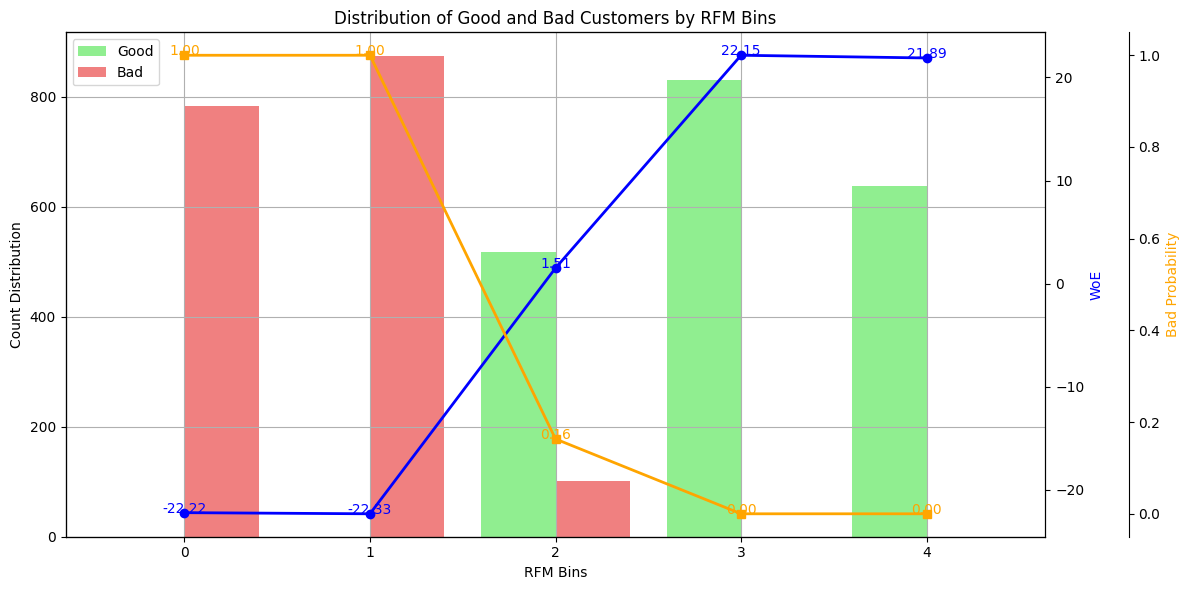

In [59]:
rfm = RFMAnalysiswoe()

# Step 1: Compute good and bad counts
good_count, bad_count = rfm.calculate_counts(rfm_summary)

# Step 2: Visualize RFM bin analysis
rfm.plot_rfm_bin_analysis(rfm_summary, good_count, bad_count)

In [65]:
rfm_df_scores.to_csv('../data/rfm_data.csv')

In [67]:
df1 = pd.read_csv('../data/rfm_data.csv')

In [68]:
df1

,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,TransactionId,CustomerId,Amount,TransactionStartTime,PricingStrategy,FraudResult,...,ChannelId_ChannelId_5,LastTransaction,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,Risk_Label
0,0,0,0.000000,0.000000,TransactionId_76871,CustomerId_4406,1000.0,2018-11-15 02:18:49+00:00,0.5,0.0,...,0.0,2019-02-12 10:24:40+00:00,2104,119,109921.75,4,3,2,2.65,Good
1,1,1,0.000010,0.000010,TransactionId_73770,CustomerId_4406,-20.0,2018-11-15 02:19:08+00:00,0.5,0.0,...,0.0,2019-02-12 10:24:40+00:00,2104,119,109921.75,4,3,2,2.65,Good
2,2,2,0.000021,0.000021,TransactionId_26203,CustomerId_4683,500.0,2018-11-15 02:44:21+00:00,0.5,0.0,...,0.0,2018-11-24 08:30:25+00:00,2184,2,1000.00,1,1,1,1.00,Bad
3,3,3,0.000031,0.000031,TransactionId_380,CustomerId_988,20000.0,2018-11-15 03:32:55+00:00,0.5,0.0,...,0.0,2019-02-08 07:53:33+00:00,2108,38,228727.20,3,2,3,2.55,Good
4,4,4,0.000042,0.000042,TransactionId_28195,CustomerId_988,-644.0,2018-11-15 03:34:21+00:00,0.5,0.0,...,0.0,2019-02-08 07:53:33+00:00,2108,38,228727.20,3,2,3,2.55,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95470,95470,95470,0.999958,0.999958,TransactionId_89881,CustomerId_3078,-1000.0,2019-02-13 09:54:09+00:00,0.5,0.0,...,0.0,2019-02-13 09:54:09+00:00,2103,573,2438140.00,4,4,4,4.00,Good
95471,95471,95471,0.999969,0.999969,TransactionId_91597,CustomerId_3874,1000.0,2019-02-13 09:54:25+00:00,0.5,0.0,...,0.0,2019-02-13 09:54:35+00:00,2103,43,58499.60,4,2,1,1.75,Bad
95472,95472,95472,0.999979,0.999979,TransactionId_82501,CustomerId_3874,-20.0,2019-02-13 09:54:35+00:00,0.5,0.0,...,0.0,2019-02-13 09:54:35+00:00,2103,43,58499.60,4,2,1,1.75,Bad
95473,95473,95473,0.999990,0.999990,TransactionId_136354,CustomerId_1709,3000.0,2019-02-13 10:01:10+00:00,0.5,0.0,...,0.0,2019-02-13 10:01:28+00:00,2103,520,840485.00,4,4,4,4.00,Good


## Additional Task: Class Imbalance Handling

### 1. Synthetic Data Generation

- Use SMOTE (Synthetic Minority Oversampling Technique) to address class imbalance.

### 2. Re-sampling Strategies

- Apply over-sampling or under-sampling techniques to balance the dataset.

### 3. Cost-Sensitive Modeling

- Use cost-sensitive algorithms or weighted loss functions to handle imbalance.

In [60]:
from imballance_handling import ImbalanceHandler

In [69]:
# Prepare features and target (ensure these are correctly defined)
features = df1.drop(columns=['Risk_Label'])  # Assuming 'Risk_Label' is the target column
target = df1['Risk_Label']


In [71]:
# Initialize the ImbalanceHandler with features and target
imbalance_handler = ImbalanceHandler(features, target)

In [73]:
from sklearn.preprocessing import LabelEncoder
# Identify non-numeric columns
non_numeric_columns = features.select_dtypes(include=['object']).columns

# Transform non-numeric columns using Label Encoding
for col in non_numeric_columns:
    label_encoder = LabelEncoder()
    features[col] = label_encoder.fit_transform(features[col])

# Ensure all features are numeric
print(features.dtypes)

Unnamed: 0.2                            int64
Unnamed: 0.1                            int64
index                                 float64
Unnamed: 0                            float64
TransactionId                           int64
CustomerId                              int64
Amount                                float64
TransactionStartTime                    int64
PricingStrategy                       float64
FraudResult                           float64
Total_Transactions                    float64
Average_Transaction                   float64
Transaction_Volume                    float64
StdDev_Transaction                    float64
Net_Amount                            float64
Total_Debits                          float64
Total_Credits                         float64
Debit_to_Credit_Ratio                 float64
Hour_of_Transaction                   float64
Day_of_Transaction                    float64
Month_of_Transaction                  float64
Year_of_Transaction               

In [74]:
# Initialize ImbalanceHandler
imbalance_handler = ImbalanceHandler(features, target)

# Apply SMOTE
X_smote, y_smote = imbalance_handler.apply_smote()
print("SMOTE Resampling Complete")

SMOTE Resampling Complete


In [75]:
# Use methods from ImbalanceHandler
# Example: Applying SMOTE
X_smote, y_smote = imbalance_handler.apply_smote()
print("SMOTE Resampling Complete")

# Example: Train using over-sampling
model_oversample = imbalance_handler.train_with_resampling(oversample=True)
print("Over-sampling Model Training Complete")

# Example: Train a cost-sensitive model
cost_sensitive_model = imbalance_handler.train_cost_sensitive_model()
print("Cost-Sensitive Model Training Complete")

SMOTE Resampling Complete
Over-sampling Model Training Complete
Cost-Sensitive Model Training Complete


In [77]:
from sklearn.model_selection import train_test_split
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Evaluate cost-sensitive model
y_pred = cost_sensitive_model.predict(X_test)
print("Evaluation Results:")
print((y_test, y_pred))

Evaluation Results:
(83903    Good
26960     Bad
11060    Good
86153     Bad
86260    Good
         ... 
91002    Good
88172     Bad
85196     Bad
39184     Bad
17147    Good
Name: Risk_Label, Length: 19095, dtype: object, array(['Good', 'Bad', 'Good', ..., 'Bad', 'Bad', 'Good'], dtype=object))


In [79]:
# 1. Class Distribution Before and After SMOTE
def plot_class_distribution(y_original, y_smote):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.countplot(x=y_original, ax=ax[0], palette='viridis')
    ax[0].set_title('Class Distribution Before SMOTE')
    ax[0].set_xlabel('Class')
    ax[0].set_ylabel('Count')

    sns.countplot(x=y_smote, ax=ax[1], palette='viridis')
    ax[1].set_title('Class Distribution After SMOTE')
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

C:\Users\Hello\AppData\Local\Temp\ipykernel_15992\2658954713.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_original, ax=ax[0], palette='viridis')
C:\Users\Hello\AppData\Local\Temp\ipykernel_15992\2658954713.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_smote, ax=ax[1], palette='viridis')


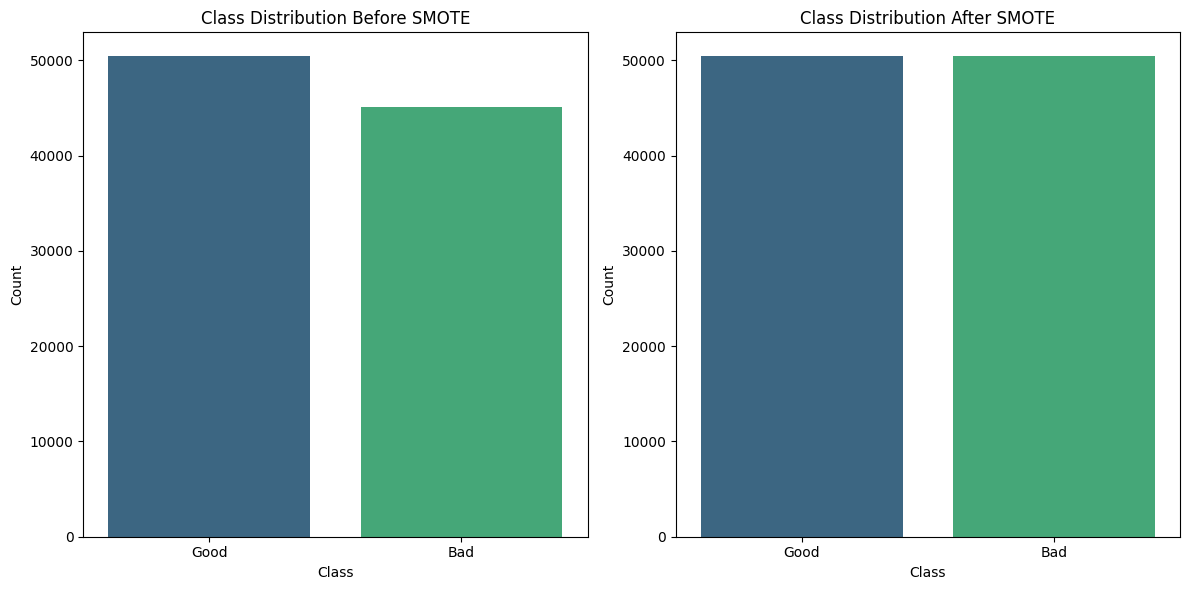

In [80]:
plot_class_distribution(target, y_smote)

In [81]:
# 2. Feature Importance (using a cost-sensitive model)
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    sorted_idx = importance.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance)), importance[sorted_idx], align='center')
    plt.yticks(range(len(importance)), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance from Cost-Sensitive Model")
    plt.show()

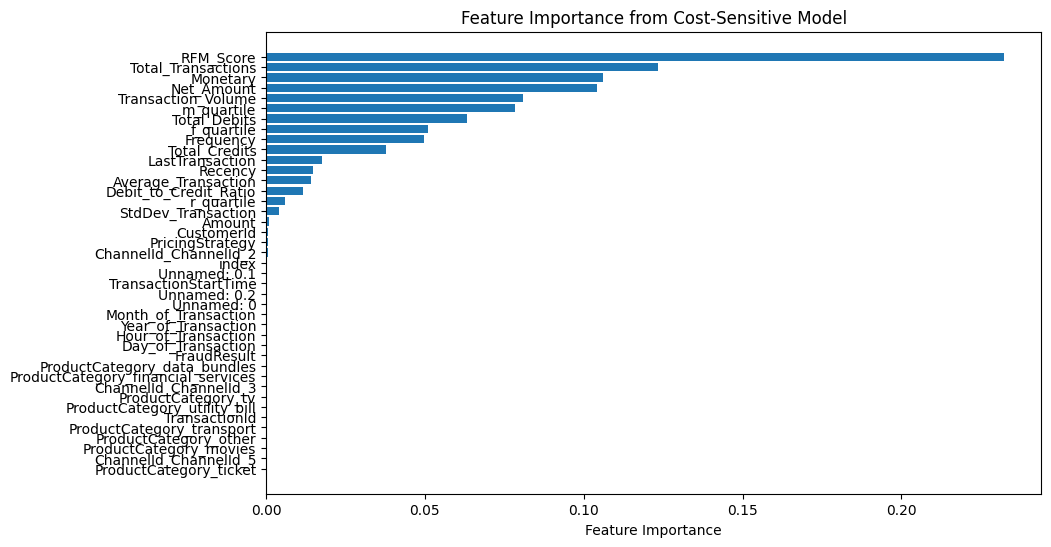

In [82]:
plot_feature_importance(cost_sensitive_model, features.columns)

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
# 3. Confusion Matrix for Each Model
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

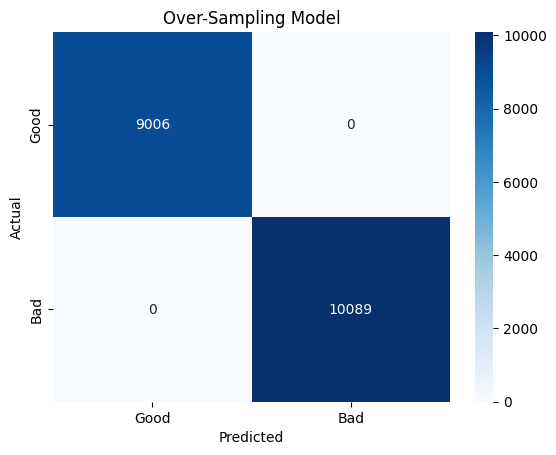

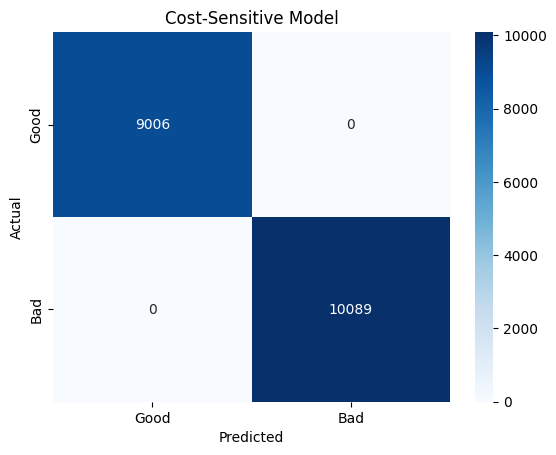

In [84]:
# Assume you split X_smote and y_smote into train/test sets
plot_confusion_matrix(model_oversample, X_test, y_test, 'Over-Sampling Model')
plot_confusion_matrix(cost_sensitive_model, X_test, y_test, 'Cost-Sensitive Model')